In [1]:
from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/custom.css").read_text(encoding="utf-8")
display(HTML(f"<style>{css}</style>"))


# Chapter 5 — Decision Trees and Variants
## Lesson 8: Handling Missing Values and Categorical Variables in Trees



Decision trees are often marketed as “works out of the box on messy tabular data.” That’s *partly* true: trees are flexible, non-linear, and require no feature scaling. But two very common realities still need careful engineering:

1. **Missing values** (NaN / null / blank) — produced by data collection gaps, sensor dropouts, partial forms, or join mismatches.
2. **Categorical variables** — strings and discrete labels such as `"HIGH"`, `"LOW"`, `"Yes"`, `"No"`, `"Premium"`, `"East"`.

Many production-grade tree implementations include model-level tricks for missingness (e.g., default directions, surrogate splits, or probabilistic routing) and for categorical features (e.g., ordered target statistics). However, **scikit-learn’s standard `DecisionTreeClassifier/Regressor` does not accept NaNs**, and it expects purely numeric input. So, in practice, you typically handle both issues in a **preprocessing pipeline**.

In this lesson you will learn **exactly how to do this correctly** (and how to avoid leakage), using multiple datasets from your repo.



### Learning objectives

By the end of this lesson you should be able to:

- Explain why missingness and categoricals are “special” for trees in different libraries.
- Diagnose missingness patterns and choose sensible strategies (drop, impute, indicator, model-native handling).
- Encode categoricals for trees (one-hot, ordinal, frequency, target encoding) and understand the bias/variance trade-offs.
- Build **leakage-safe** pipelines with `ColumnTransformer` + `Pipeline` and evaluate them with cross-validation.
- Implement a **safe target encoder** (out-of-fold) and understand when it’s worth the complexity.



### Environment setup

We will use `pandas`, `numpy`, `matplotlib`, and `scikit-learn`.

**Important:** dataset paths are relative to the notebook location. For Chapter 5 notebooks, use:

- `../../../Datasets/Classification/...`
- `../../../Datasets/Regression/...`
- `../../../Datasets/Clustering/...` (not used in this lesson, but kept for consistency)

If you run this notebook outside the repo, update the paths accordingly.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    mean_absolute_error, mean_squared_error
)
# sklearn 1.4+ deprecates mean_squared_error(..., squared=False) in favor of root_mean_squared_error
try:
    from sklearn.metrics import root_mean_squared_error
except Exception:
    def root_mean_squared_error(y_true, y_pred):
        return mean_squared_error(y_true, y_pred, squared=False)

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_text

np.random.seed(42)



## 1) Missing values in decision trees: what’s going on?

### 1.1 Why missing values are not “just another value”
A standard CART-style split compares a feature against a threshold (numeric) or membership (categorical) and sends a sample left or right. If a value is missing, the model has no obvious rule for routing the sample.

In a *pure* numeric split, we evaluate a condition such as:

$$
x_j \le t
$$

But if $x_j$ is NaN, the comparison is undefined. That is why many libraries require you to decide how to treat missingness **before** fitting a classic decision tree.

### 1.2 Common strategies used by tree implementations (conceptual)
Different libraries implement different strategies:

- **Drop rows** with missing features (simple but can bias data and waste signal).
- **Impute** missing values (mean/median for numeric, mode for categorical, or a dedicated “Missing” category).
- **Missing indicator**: add a binary feature $m_j = \mathbb{1}[x_j \text{ is missing}]$ so the tree can learn “missingness is informative.”
- **Default direction** (common in gradient-boosted trees): learn where missing values go at each split.
- **Surrogate splits** (classic CART idea): if the primary split feature is missing, use a secondary feature that best mimics the split.
- **Probabilistic routing**: send missing samples left/right proportionally to observed frequencies.

In scikit-learn’s classic `DecisionTree*`, you usually choose **imputation + (optional) indicator**.



### 1.3 Practical decision checklist (for tabular ML)

Use this checklist when you see missingness:

1. **Measure** missingness rate per feature and per row.
2. If missingness is tiny (e.g., < 1%), test **dropping** rows as a baseline.
3. For numeric features, start with **median** imputation (robust to outliers).
4. For categorical features, start with **most_frequent** or a constant `"__MISSING__"` category.
5. Add **missing indicators** if you suspect missingness is informative (common in real-world data).
6. Validate choices using cross-validation; don’t guess.

We’ll apply this checklist in code.



## 2) Example 1 (Classification): `drug200.csv`

This dataset is ideal for this lesson because:
- It contains **categorical features** (`Sex`, `BP`, `Cholesterol`).
- It has numeric features (`Age`, `Na_to_K`).
- The target is multi-class (`Drug`).

We will:
1. Load the dataset.
2. Inject missing values (so we can test strategies deterministically).
3. Compare pipelines:
   - Baseline: drop missing rows.
   - Pipeline A: impute + one-hot.
   - Pipeline B: impute + one-hot + missing-indicator (via constant category for categoricals, and median for numeric).


In [3]:
# Load Drug200 dataset
path_drug = "../../../Datasets/Classification/drug200.csv"
df_drug = pd.read_csv(path_drug)

df_drug.head()


,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


In [4]:
# Create a controlled missingness scenario for demonstration:
# - Make ~8% of Sex missing
# - Make ~10% of BP missing
# - Make ~5% of Na_to_K missing

df = df_drug.copy()

rng = np.random.default_rng(42)
n = len(df)

for col, rate in [("Sex", 0.08), ("BP", 0.10), ("Na_to_K", 0.05)]:
    idx = rng.choice(n, size=int(rate * n), replace=False)
    df.loc[idx, col] = np.nan

missing_rates = df.isna().mean().sort_values(ascending=False)
missing_rates


BP             0.10
Sex            0.08
Na_to_K        0.05
Age            0.00
Cholesterol    0.00
Drug           0.00
dtype: float64

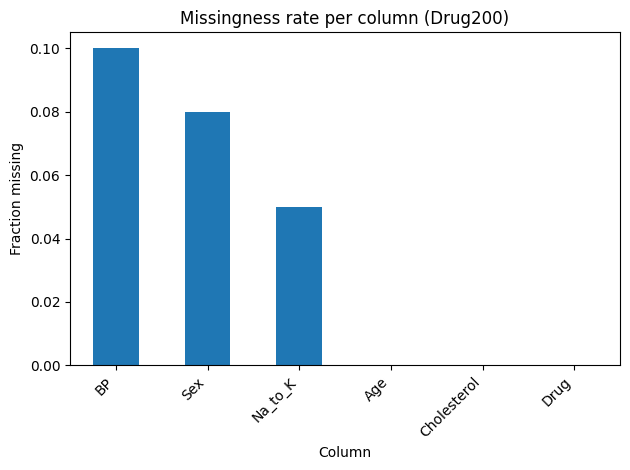

In [5]:
# Visualize missingness per column (simple bar plot)
plt.figure()
missing_rates.plot(kind="bar")
plt.title("Missingness rate per column (Drug200)")
plt.xlabel("Column")
plt.ylabel("Fraction missing")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()



### 2.1 Build pipelines (leakage-safe)

A **leakage-safe** workflow means:
- Split into train/test *first* (or use CV).
- Fit imputers and encoders **only on training folds**.
- Apply the fitted transformations to validation/test folds.

`Pipeline` and `ColumnTransformer` enforce that discipline.


In [6]:
X = df.drop(columns=["Drug"])
y = df["Drug"]

# Identify columns by type
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

cat_cols, num_cols


(['Sex', 'BP', 'Cholesterol'], ['Age', 'Na_to_K'])

In [7]:
# Train/test split (stratified for classification)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Baseline: drop rows with any missing values (train and test separately)
train_mask = X_train.notna().all(axis=1)
test_mask  = X_test.notna().all(axis=1)

X_train_drop = X_train.loc[train_mask].copy()
y_train_drop = y_train.loc[train_mask].copy()
X_test_drop  = X_test.loc[test_mask].copy()
y_test_drop  = y_test.loc[test_mask].copy()

baseline_clf = DecisionTreeClassifier(random_state=42, max_depth=5)
baseline_clf.fit(pd.get_dummies(X_train_drop, drop_first=False), y_train_drop)

# Align dummy columns between train and test
X_test_dum = pd.get_dummies(X_test_drop, drop_first=False)
X_train_dum = pd.get_dummies(X_train_drop, drop_first=False)
X_test_dum = X_test_dum.reindex(columns=X_train_dum.columns, fill_value=0)

y_pred_base = baseline_clf.predict(X_test_dum)

print("Baseline (drop missing rows + get_dummies)")
print("Test accuracy:", accuracy_score(y_test_drop, y_pred_base))


Baseline (drop missing rows + get_dummies)
Test accuracy: 0.975609756097561


In [8]:
# Pipeline A: Impute + OneHot + Decision Tree
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocess_A = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

pipe_A = Pipeline(steps=[
    ("preprocess", preprocess_A),
    ("model", DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_leaf=5)),
])

pipe_A.fit(X_train, y_train)
y_pred_A = pipe_A.predict(X_test)

print("Pipeline A (median/mode impute + one-hot)")
print("Test accuracy:", accuracy_score(y_test, y_pred_A))


Pipeline A (median/mode impute + one-hot)
Test accuracy: 0.98



### 2.2 A simple way to let the tree “see” missingness

A robust trick for categoricals is to impute with a constant token (e.g., `"__MISSING__"`). After one-hot encoding, this produces a dedicated indicator column that the tree can split on.

For numeric features, you can add explicit missing indicators, but to keep dependencies minimal we’ll show the categorical-indicator approach (and discuss numeric indicators conceptually).


In [9]:
# Pipeline B: Impute categorical with a constant token so missingness becomes a category
categorical_transformer_B = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="__MISSING__")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocess_B = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),  # numeric still median-imputed
        ("cat", categorical_transformer_B, cat_cols),
    ]
)

pipe_B = Pipeline(steps=[
    ("preprocess", preprocess_B),
    ("model", DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_leaf=5)),
])

pipe_B.fit(X_train, y_train)
y_pred_B = pipe_B.predict(X_test)

print("Pipeline B (constant categorical impute => missing indicator via one-hot)")
print("Test accuracy:", accuracy_score(y_test, y_pred_B))


Pipeline B (constant categorical impute => missing indicator via one-hot)
Test accuracy: 0.96


In [10]:
print("Classification report (Pipeline B)")
print(classification_report(y_test, y_pred_B))

cm = confusion_matrix(y_test, y_pred_B)
cm_df = pd.DataFrame(cm, index=pipe_B.classes_, columns=pipe_B.classes_)
cm_df


Classification report (Pipeline B)
              precision    recall  f1-score   support

       DrugY       0.96      1.00      0.98        23
       drugA       1.00      1.00      1.00         6
       drugB       1.00      0.75      0.86         4
       drugC       1.00      1.00      1.00         4
       drugX       0.92      0.92      0.92        13

    accuracy                           0.96        50
   macro avg       0.98      0.93      0.95        50
weighted avg       0.96      0.96      0.96        50



,DrugY,drugA,drugB,drugC,drugX
DrugY,23,0,0,0,0
drugA,0,6,0,0,0
drugB,0,0,3,0,1
drugC,0,0,0,4,0
drugX,1,0,0,0,12



### 2.3 Inspecting the learned rules

Trees are easy to inspect. After preprocessing, we can extract the model and print a text summary of the split rules.

Note: once you one-hot encode, feature names expand; we’ll reconstruct them from the `ColumnTransformer`.


In [11]:
# Helper to recover feature names after ColumnTransformer
def get_feature_names_from_column_transformer(ct: ColumnTransformer):
    output_features = []
    for name, trans, cols in ct.transformers_:
        if name == "remainder":
            continue
        if hasattr(trans, "named_steps"):
            last = list(trans.named_steps.values())[-1]
        else:
            last = trans
        if hasattr(last, "get_feature_names_out"):
            try:
                fn = last.get_feature_names_out(cols)
            except TypeError:
                fn = last.get_feature_names_out()
            output_features.extend(fn.tolist())
        else:
            # Numeric pipeline typically doesn't change names
            if isinstance(cols, (list, tuple)):
                output_features.extend(list(cols))
            else:
                output_features.append(str(cols))
    return output_features

ct = pipe_B.named_steps["preprocess"]
feature_names = get_feature_names_from_column_transformer(ct)

dt = pipe_B.named_steps["model"]
rules = export_text(dt, feature_names=feature_names, max_depth=3)
print(rules[:4000])


|--- Na_to_K <= 14.63
|   |--- BP_HIGH <= 0.50
|   |   |--- BP_LOW <= 0.50
|   |   |   |--- BP_NORMAL <= 0.50
|   |   |   |   |--- class: drugX
|   |   |   |--- BP_NORMAL >  0.50
|   |   |   |   |--- truncated branch of depth 2
|   |   |--- BP_LOW >  0.50
|   |   |   |--- Cholesterol_HIGH <= 0.50
|   |   |   |   |--- truncated branch of depth 2
|   |   |   |--- Cholesterol_HIGH >  0.50
|   |   |   |   |--- class: drugC
|   |--- BP_HIGH >  0.50
|   |   |--- Age <= 50.00
|   |   |   |--- Age <= 28.50
|   |   |   |   |--- class: drugA
|   |   |   |--- Age >  28.50
|   |   |   |   |--- class: drugA
|   |   |--- Age >  50.00
|   |   |   |--- class: drugB
|--- Na_to_K >  14.63
|   |--- class: DrugY




## 3) Categorical variables in trees: options and trade-offs

### 3.1 One-hot encoding (OHE)
**Pros**
- No false ordering.
- Works well for low/medium cardinality categoricals.
- Splits are interpretable (e.g., `BP_HIGH` vs not).

**Cons**
- High cardinality can explode dimensionality (memory/time).
- Trees can overfit by splitting on rare categories.

### 3.2 Ordinal encoding
Map categories to integers (e.g., `LOW→0`, `NORMAL→1`, `HIGH→2`).

**Pros**
- Compact, fast.
- Works well if categories have a real order (e.g., education level).

**Cons**
- Introduces an *artificial* ordering if no true order exists.
- Trees might create “threshold” splits that group categories in unintended ways.

### 3.3 Frequency / count encoding
Replace each category by its frequency in training data.

**Pros**
- Very compact.
- Sometimes surprisingly strong for high-cardinality features.
- Encodes “rarity” which often correlates with interesting outcomes.

**Cons**
- Loses identity of categories; different categories with same frequency become identical.

### 3.4 Target encoding (mean encoding)
Replace a category by the mean target value for that category (classification: mean of $y=1$ in binary; regression: mean of $y$).

**Pros**
- Powerful for high-cardinality features.

**Cons (critical!)**
- High leakage risk if you compute category means using the full dataset.
- Must be done *out-of-fold* or with strong smoothing and CV discipline.



## 4) Example 2 (Regression): `house-prices.csv`

We now switch to a regression task. This dataset includes:
- Numeric: `SqFt`, `Bedrooms`, `Bathrooms`, `Offers`
- Categorical: `Brick`, `Neighborhood`
- Target: `Price`

We will:
- Inject missingness into `Brick` and `SqFt`.
- Compare one-hot vs ordinal encoding for `Neighborhood`.
- Evaluate with MAE and RMSE.


In [12]:
path_house = "../../../Datasets/Regression/house-prices.csv"
df_house = pd.read_csv(path_house)

df_house.head()


,Home,Price,SqFt,Bedrooms,Bathrooms,Offers,Brick,Neighborhood
0,1,114300,1790,2,2,2,No,East
1,2,114200,2030,4,2,3,No,East
2,3,114800,1740,3,2,1,No,East
3,4,94700,1980,3,2,3,No,East
4,5,119800,2130,3,3,3,No,East


In [13]:
df2 = df_house.copy()
rng = np.random.default_rng(123)

# Inject some missingness
n2 = len(df2)
df2.loc[rng.choice(n2, size=max(1, int(0.08*n2)), replace=False), "Brick"] = np.nan
df2.loc[rng.choice(n2, size=max(1, int(0.05*n2)), replace=False), "SqFt"] = np.nan

df2.isna().mean().sort_values(ascending=False)


Brick           0.078125
SqFt            0.046875
Price           0.000000
Home            0.000000
Bedrooms        0.000000
Bathrooms       0.000000
Offers          0.000000
Neighborhood    0.000000
dtype: float64

In [14]:
Xh = df2.drop(columns=["Price"])
yh = df2["Price"]

cat_cols_h = Xh.select_dtypes(include=["object"]).columns.tolist()
num_cols_h = [c for c in Xh.columns if c not in cat_cols_h]

Xh_train, Xh_test, yh_train, yh_test = train_test_split(
    Xh, yh, test_size=0.25, random_state=42
)

numeric_trans_h = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

# One-hot version
cat_trans_ohe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="__MISSING__")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocess_ohe = ColumnTransformer(
    transformers=[
        ("num", numeric_trans_h, num_cols_h),
        ("cat", cat_trans_ohe, cat_cols_h),
    ]
)

pipe_ohe = Pipeline(steps=[
    ("preprocess", preprocess_ohe),
    ("model", DecisionTreeRegressor(random_state=42, max_depth=6, min_samples_leaf=5)),
])

pipe_ohe.fit(Xh_train, yh_train)
pred_ohe = pipe_ohe.predict(Xh_test)

mae_ohe = mean_absolute_error(yh_test, pred_ohe)
rmse_ohe = root_mean_squared_error(yh_test, pred_ohe)

mae_ohe, rmse_ohe


(np.float64(10255.600198412696), np.float64(14559.534126574883))

In [15]:
# Ordinal encoding version for categoricals (compact, but may impose false order)
cat_trans_ord = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="__MISSING__")),
    ("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)),
])

preprocess_ord = ColumnTransformer(
    transformers=[
        ("num", numeric_trans_h, num_cols_h),
        ("cat", cat_trans_ord, cat_cols_h),
    ]
)

pipe_ord = Pipeline(steps=[
    ("preprocess", preprocess_ord),
    ("model", DecisionTreeRegressor(random_state=42, max_depth=6, min_samples_leaf=5)),
])

pipe_ord.fit(Xh_train, yh_train)
pred_ord = pipe_ord.predict(Xh_test)

mae_ord = mean_absolute_error(yh_test, pred_ord)
rmse_ord = root_mean_squared_error(yh_test, pred_ord)

mae_ord, rmse_ord


(np.float64(9346.755952380952), np.float64(12815.69685188128))


### 4.1 Interpretation

You might see either encoding win depending on:
- dataset size (this one is small),
- tree depth / min leaf size,
- how much signal the categorical provides,
- and whether the imposed ordinal order accidentally helps or hurts.

In general:
- **OHE** is the safe default when category count is modest.
- **Ordinal** can be okay when there is a natural order or when you control splits with strong regularization (e.g., shallow trees, larger `min_samples_leaf`).

Now we’ll move to a more advanced topic: **target encoding** for high-cardinality categoricals.



## 5) Target encoding without leakage (advanced but practical)

Target encoding replaces a category with a statistic of the target for that category.

For regression, a basic target encoding is:

$$
\text{TE}(c) = \mathbb{E}[y \mid x=c]
$$

For binary classification, it is often the positive rate $\mathbb{P}(y=1 \mid x=c)$.

### Why leakage happens
If you compute $\mathbb{E}[y \mid x=c]$ using the full dataset and then train a model, you have “peeked” at the target for each sample’s category — the encoding includes the sample’s own label. For rare categories, this can be extreme leakage, giving artificially high validation scores and poor real-world performance.

### The fix: out-of-fold encoding
During cross-validation:
- For each fold, compute category means using **only the training fold**.
- Apply them to the validation fold.
- Optionally apply smoothing toward the global mean to reduce variance.

Below is a minimal, dependency-free implementation that works with scikit-learn pipelines.


In [16]:
from sklearn.base import BaseEstimator, TransformerMixin

class TargetMeanEncoderOOF(BaseEstimator, TransformerMixin):
    """Out-of-fold target mean encoder for a single categorical column.

    - During fit_transform(X_train, y_train): produces OOF encodings (no self-leakage).
    - During transform(X_test): uses mapping fitted on full training data.
    - Uses smoothing to shrink rare-category means toward the global mean.
    """
    def __init__(self, smoothing=20.0, n_splits=5, random_state=42):
        self.smoothing = float(smoothing)
        self.n_splits = int(n_splits)
        self.random_state = int(random_state)

    def _fit_mapping(self, s, y):
        global_mean = y.mean()
        stats = y.groupby(s).agg(["mean", "count"])
        stats["smooth"] = (stats["count"] * stats["mean"] + self.smoothing * global_mean) / (stats["count"] + self.smoothing)
        mapping = stats["smooth"].to_dict()
        return global_mean, mapping

    def fit(self, X, y):
        X_df = pd.DataFrame(X)
        s = X_df.iloc[:, 0].astype("object")
        y = pd.Series(y).reset_index(drop=True)
        self.global_mean_, self.mapping_ = self._fit_mapping(s, y)
        return self

    def fit_transform(self, X, y):
        X_df = pd.DataFrame(X)
        s = X_df.iloc[:, 0].astype("object").reset_index(drop=True)
        y = pd.Series(y).reset_index(drop=True)

        kf = KFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)
        oof = np.empty(len(y), dtype=float)

        for tr_idx, va_idx in kf.split(s):
            s_tr, y_tr = s.iloc[tr_idx], y.iloc[tr_idx]
            global_mean, mapping = self._fit_mapping(s_tr, y_tr)
            enc = s.iloc[va_idx].map(mapping).fillna(global_mean).astype(float)
            oof[va_idx] = enc.values

        # Fit mapping on full data for later transform
        self.global_mean_, self.mapping_ = self._fit_mapping(s, y)

        return pd.DataFrame(oof, columns=["__target_mean"])

    def transform(self, X):
        X_df = pd.DataFrame(X)
        s = X_df.iloc[:, 0].astype("object")
        out = s.map(self.mapping_).fillna(self.global_mean_).astype(float)
        return out.to_frame(name="__target_mean")



## 6) Example 3 (Regression + high-cardinality categoricals): `listings.csv`

This dataset has many real-world categorical columns (e.g., neighborhoods, room types). High-cardinality categoricals are common in product ML (users, items, locations).

We will:
- Build a small regression task: predict `price` from a subset of features.
- Compare:
  - One-hot encoding
  - Frequency encoding
  - Target encoding (our leakage-aware encoder)

To keep runtime reasonable, we will sample rows.


In [17]:
path_listings = "../../../Datasets/Regression/listings.csv"
df_list = pd.read_csv(path_listings)

# Basic cleanup: ensure numeric price
df_list["price"] = pd.to_numeric(df_list["price"], errors="coerce")

# Choose a subset of features (mix of numeric + categorical)
use_cols = ["latitude", "longitude", "minimum_nights", "number_of_reviews", "room_type", "neighbourhood"]
df_list = df_list[use_cols + ["price"]].dropna(subset=["price"]).copy()

# Sample for speed (adjust as needed) and RESET INDEX to avoid .loc KeyError later
df_list = df_list.sample(n=min(3000, len(df_list)), random_state=42).reset_index(drop=True)

df_list.head()


,latitude,longitude,minimum_nights,number_of_reviews,room_type,neighbourhood,price
0,51.490900,-0.137670,2,20,Entire home/apt,Westminster,244.0
1,51.517378,0.012742,1,20,Private room,Newham,51.0
2,51.498490,-0.181320,1,42,Entire home/apt,Kensington and Chelsea,338.0
3,51.466316,0.112080,1,1,Entire home/apt,Bexley,152.0
4,51.539760,-0.165780,5,2,Entire home/apt,Camden,131.0


In [18]:
# Inject a bit of missingness into categoricals to demonstrate handling
rng = np.random.default_rng(7)
n3 = len(df_list)

# IMPORTANT: df_list index is 0..n3-1 (we reset_index above), so .loc with idx works safely.
for col, rate in [("room_type", 0.05), ("neighbourhood", 0.05)]:
    idx = rng.choice(n3, size=max(1, int(rate*n3)), replace=False)
    df_list.loc[idx, col] = np.nan

df_list.isna().mean().sort_values(ascending=False)


room_type            0.05
neighbourhood        0.05
latitude             0.00
minimum_nights       0.00
longitude            0.00
number_of_reviews    0.00
price                0.00
dtype: float64

In [19]:
from sklearn.base import BaseEstimator, TransformerMixin

class FrequencyEncoder(BaseEstimator, TransformerMixin):
    """Frequency (count) encoder for a single categorical column.

    Works with:
    - pandas DataFrame (single column)
    - numpy array with shape (n_samples, 1) (common after SimpleImputer)
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        X_df = pd.DataFrame(X)
        s = X_df.iloc[:, 0].astype("object")
        freqs = s.value_counts(dropna=False)
        self.mapping_ = (freqs / freqs.sum()).to_dict()
        return self

    def transform(self, X):
        X_df = pd.DataFrame(X)
        s = X_df.iloc[:, 0].astype("object")
        out = s.map(self.mapping_).fillna(0.0).astype(float)
        return out.to_frame(name="__freq")


In [20]:
Xl = df_list.drop(columns=["price"])
yl = df_list["price"]

cat_cols_l = Xl.select_dtypes(include=["object"]).columns.tolist()
num_cols_l = [c for c in Xl.columns if c not in cat_cols_l]

Xl_train, Xl_test, yl_train, yl_test = train_test_split(Xl, yl, test_size=0.25, random_state=42)

numeric_trans_l = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

# --- One-hot pipeline ---
cat_ohe_l = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="__MISSING__")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

pre_ohe_l = ColumnTransformer([
    ("num", numeric_trans_l, num_cols_l),
    ("cat", cat_ohe_l, cat_cols_l),
])

pipe_ohe_l = Pipeline(steps=[
    ("preprocess", pre_ohe_l),
    ("model", DecisionTreeRegressor(random_state=42, max_depth=8, min_samples_leaf=20)),
])

pipe_ohe_l.fit(Xl_train, yl_train)
pred_ohe_l = pipe_ohe_l.predict(Xl_test)

mae_ohe_l = mean_absolute_error(yl_test, pred_ohe_l)
rmse_ohe_l = root_mean_squared_error(yl_test, pred_ohe_l)

# --- Frequency encoding pipeline (per categorical column) ---
pre_freq_l = ColumnTransformer(
    [("num", numeric_trans_l, num_cols_l)] +
    [(f"freq_{c}", Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="__MISSING__")),
        ("freq", FrequencyEncoder()),
    ]), [c]) for c in cat_cols_l]
)

pipe_freq_l = Pipeline(steps=[
    ("preprocess", pre_freq_l),
    ("model", DecisionTreeRegressor(random_state=42, max_depth=8, min_samples_leaf=20)),
])

pipe_freq_l.fit(Xl_train, yl_train)
pred_freq_l = pipe_freq_l.predict(Xl_test)

mae_freq_l = mean_absolute_error(yl_test, pred_freq_l)
rmse_freq_l = root_mean_squared_error(yl_test, pred_freq_l)

# --- Target mean encoding (OOF) pipeline ---
pre_te_l = ColumnTransformer(
    [("num", numeric_trans_l, num_cols_l)] +
    [(f"te_{c}", Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="__MISSING__")),
        ("te", TargetMeanEncoderOOF(smoothing=20.0, n_splits=5, random_state=42)),
    ]), [c]) for c in cat_cols_l]
)

pipe_te_l = Pipeline(steps=[
    ("preprocess", pre_te_l),
    ("model", DecisionTreeRegressor(random_state=42, max_depth=8, min_samples_leaf=20)),
])

pipe_te_l.fit(Xl_train, yl_train)
pred_te_l = pipe_te_l.predict(Xl_test)

mae_te_l = mean_absolute_error(yl_test, pred_te_l)
rmse_te_l = root_mean_squared_error(yl_test, pred_te_l)

pd.DataFrame({
    "Encoding": ["OneHot", "Frequency", "TargetMean(OOF)"],
    "MAE": [mae_ohe_l, mae_freq_l, mae_te_l],
    "RMSE": [rmse_ohe_l, rmse_freq_l, rmse_te_l],
})


,Encoding,MAE,RMSE
0,OneHot,81.987527,148.026645
1,Frequency,84.202082,151.403117
2,TargetMean(OOF),85.993144,150.802625



### 6.1 Takeaways

- One-hot often wins when cardinality is moderate and data size is sufficient, but it can be memory-heavy.
- Frequency encoding is a compact “cheap baseline” that sometimes performs surprisingly well.
- Target encoding can be strong for high-cardinality, but its real value depends on:
  - enough data per category,
  - leakage-safe implementation,
  - and appropriate smoothing / regularization.

**Rule of thumb:** start with OHE; if you have hundreds/thousands of categories (e.g., user IDs, product IDs, neighborhoods), evaluate frequency or target encoding with disciplined cross-validation.



## 7) Best practices summary (trees + missing + categoricals)

### Missing values
- **Start simple:** median/mode imputation.
- For categorical missingness, prefer a dedicated token `"__MISSING__"` so missingness becomes an explicit feature after OHE.
- Use missing indicators if missingness might carry information.
- Prefer pipelines to avoid leakage.

### Categorical variables
- Default: **OneHotEncoder(handle_unknown="ignore")**.
- If you have very high cardinality:
  - evaluate **frequency** or **target encoding**,
  - use smoothing and out-of-fold discipline for target encoding,
  - control tree capacity: `max_depth`, `min_samples_leaf`, `min_samples_split`.

### Capacity control (prevents overfitting on rare categories)
- Increase `min_samples_leaf` (very effective).
- Limit `max_depth`.
- Consider post-pruning or ensembles (next chapter).



## 8) Exercises (with guidance)

1. **Drug200 robustness**
   - Increase missingness to 20% in `BP` and 20% in `Sex`.
   - Compare Pipeline A vs Pipeline B again.
   - Which pipeline degrades more slowly? Why?

2. **House prices sensitivity**
   - Vary `max_depth` from 2 to 12 for the OHE pipeline.
   - Plot depth vs RMSE.
   - Explain the bias–variance pattern you see.

3. **High-cardinality experiment**
   - In `listings.csv`, add `neighbourhood_group` (if present) and compare encodings again.
   - Try different smoothing values for `TargetMeanEncoder` (e.g., 1, 10, 50, 200).

4. **New dataset challenge**
   - Use `../../../Datasets/Classification/stars.csv` (categoricals: `Color`, `Spectral_Class`) to predict `Type`.
   - Implement a classification pipeline with constant-impute + OHE.
   - Add class weighting or depth control if you see imbalance.

5. **Write-up**
   - In 5–10 bullet points, document your final recommendation for “trees + missing + categoricals” for a real project.



### What’s next?

In the next lesson we will discuss **tree stability and variance**, why small data changes can create different trees, and how this motivates bagging and random forests.
